In [1]:
# EDA : Исследование зависимостей

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 16, 8
import time

start_time = time.time()

for type_ in ["f2", "f4"]:
        print (np.finfo(type_))
for type_ in ["i1", "i2", "i4"]:
    print (np.iinfo(type_))

buildings = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz")
weather = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz")
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz")

Machine parameters for float16
---------------------------------------------------------------
precision =   3   resolution = 1.00040e-03
machep =    -10   eps =        9.76562e-04
negep =     -11   epsneg =     4.88281e-04
minexp =    -14   tiny =       6.10352e-05
maxexp =     16   max =        6.55040e+04
nexp =        5   min =        -max
smallest_normal = 6.10352e-05   smallest_subnormal = 5.96046e-08
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
smallest_normal = 1.1754944e-38   smallest_subnormal = 1.4012985e-45
---------------------------------------------------------------

Machine parameters for int8
------

In [2]:
# потребление памяти
print("Строения:", buildings.memory_usage().sum() / 1024**2, "MB")
print("Погода:", weather.memory_usage().sum() / 1024**2, "MB")
print("Энергия:", energy.memory_usage().sum() / 1024**2, "MB")

Строения: 0.0664520263671875 MB
Погода: 9.597572326660156 MB
Энергия: 368.06988525390625 MB


In [3]:
# функция оптимизации памяти


def reduce_mem_usage (df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == "float":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == "int":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo("i8").min and c_max < np.iinfo("i8").max:
                df[col] = df[col].astype(np.int64)
        elif col == "timestamp":
            df[col] = pd.to_datetime(df[col])
        elif str(col_type)[:8] != "datetime":
            df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / 1024**2
    print('Потребление памяти меньше на',
            round(start_mem - end_mem, 2),
            'Мб (минус',
            round(100 * (start_mem - end_mem) / start_mem, 1),
            '%)')
    return df

In [4]:
# оптимизация памяти : строения
buildings = reduce_mem_usage(buildings)
print(buildings.info())

Потребление памяти меньше на 0.05 Мб (минус 73.9 %)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   site_id      1449 non-null   int8    
 1   building_id  1449 non-null   int16   
 2   primary_use  1449 non-null   category
 3   square_feet  1449 non-null   int32   
 4   year_built   675 non-null    float16 
 5   floor_count  355 non-null    float16 
dtypes: category(1), float16(2), int16(1), int32(1), int8(1)
memory usage: 17.8 KB
None


In [5]:
# оптимизация памяти : погода
weather = reduce_mem_usage(weather)
print(weather.info())

Потребление памяти меньше на 6.53 Мб (минус 68.1 %)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float16       
 3   cloud_coverage      70600 non-null   float16       
 4   dew_temperature     139660 non-null  float16       
 5   precip_depth_1_hr   89484 non-null   float16       
 6   sea_level_pressure  129155 non-null  float16       
 7   wind_direction      133505 non-null  float16       
 8   wind_speed          139469 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB
None


In [6]:
# оптимизация памяти : энергия
energy = reduce_mem_usage(energy)
print(energy.info())


Потребление памяти меньше на 195.54 Мб (минус 53.1 %)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12060910 entries, 0 to 12060909
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 172.5 MB
None


In [7]:
def round_fillna(df, columns):
    for col in columns:
        type_ = "int8"
        if col in ["wind_direction", "year_build", "precip_depth_1_hr"]:
            type_ = "int16"
        if col == "precip_depth_1_hr":
            df[col] = df[col].apply(lambda x:0 if x < 0 else x)
        df[col] = np.round(df[col].fillna(value = 0).astype(type_))
    return df


In [8]:

# объединение данных и очистка
energy = pd.merge(left = energy, 
        right = buildings,
        how = "left",
        left_on = "building_id",
        right_on = "building_id")
energy = energy.set_index(["timestamp",
        "site_id"])
weather = weather.set_index(["timestamp",
        "site_id"])
energy = pd.merge(left = energy, 
        right = weather,
        how = "left",
        left_index = True,
        right_index = True)
energy.reset_index(inplace = True)
energy = energy.drop(columns = ["meter"],
        axis = 1)
energy = round_fillna(energy, ["wind_direction", 
            "wind_speed", 
            "cloud_coverage",
            "precip_depth_1_hr",
            "year_built",
            "floor_count"])
energy = energy[energy["meter_reading"] > 0]

del buildings
del weather


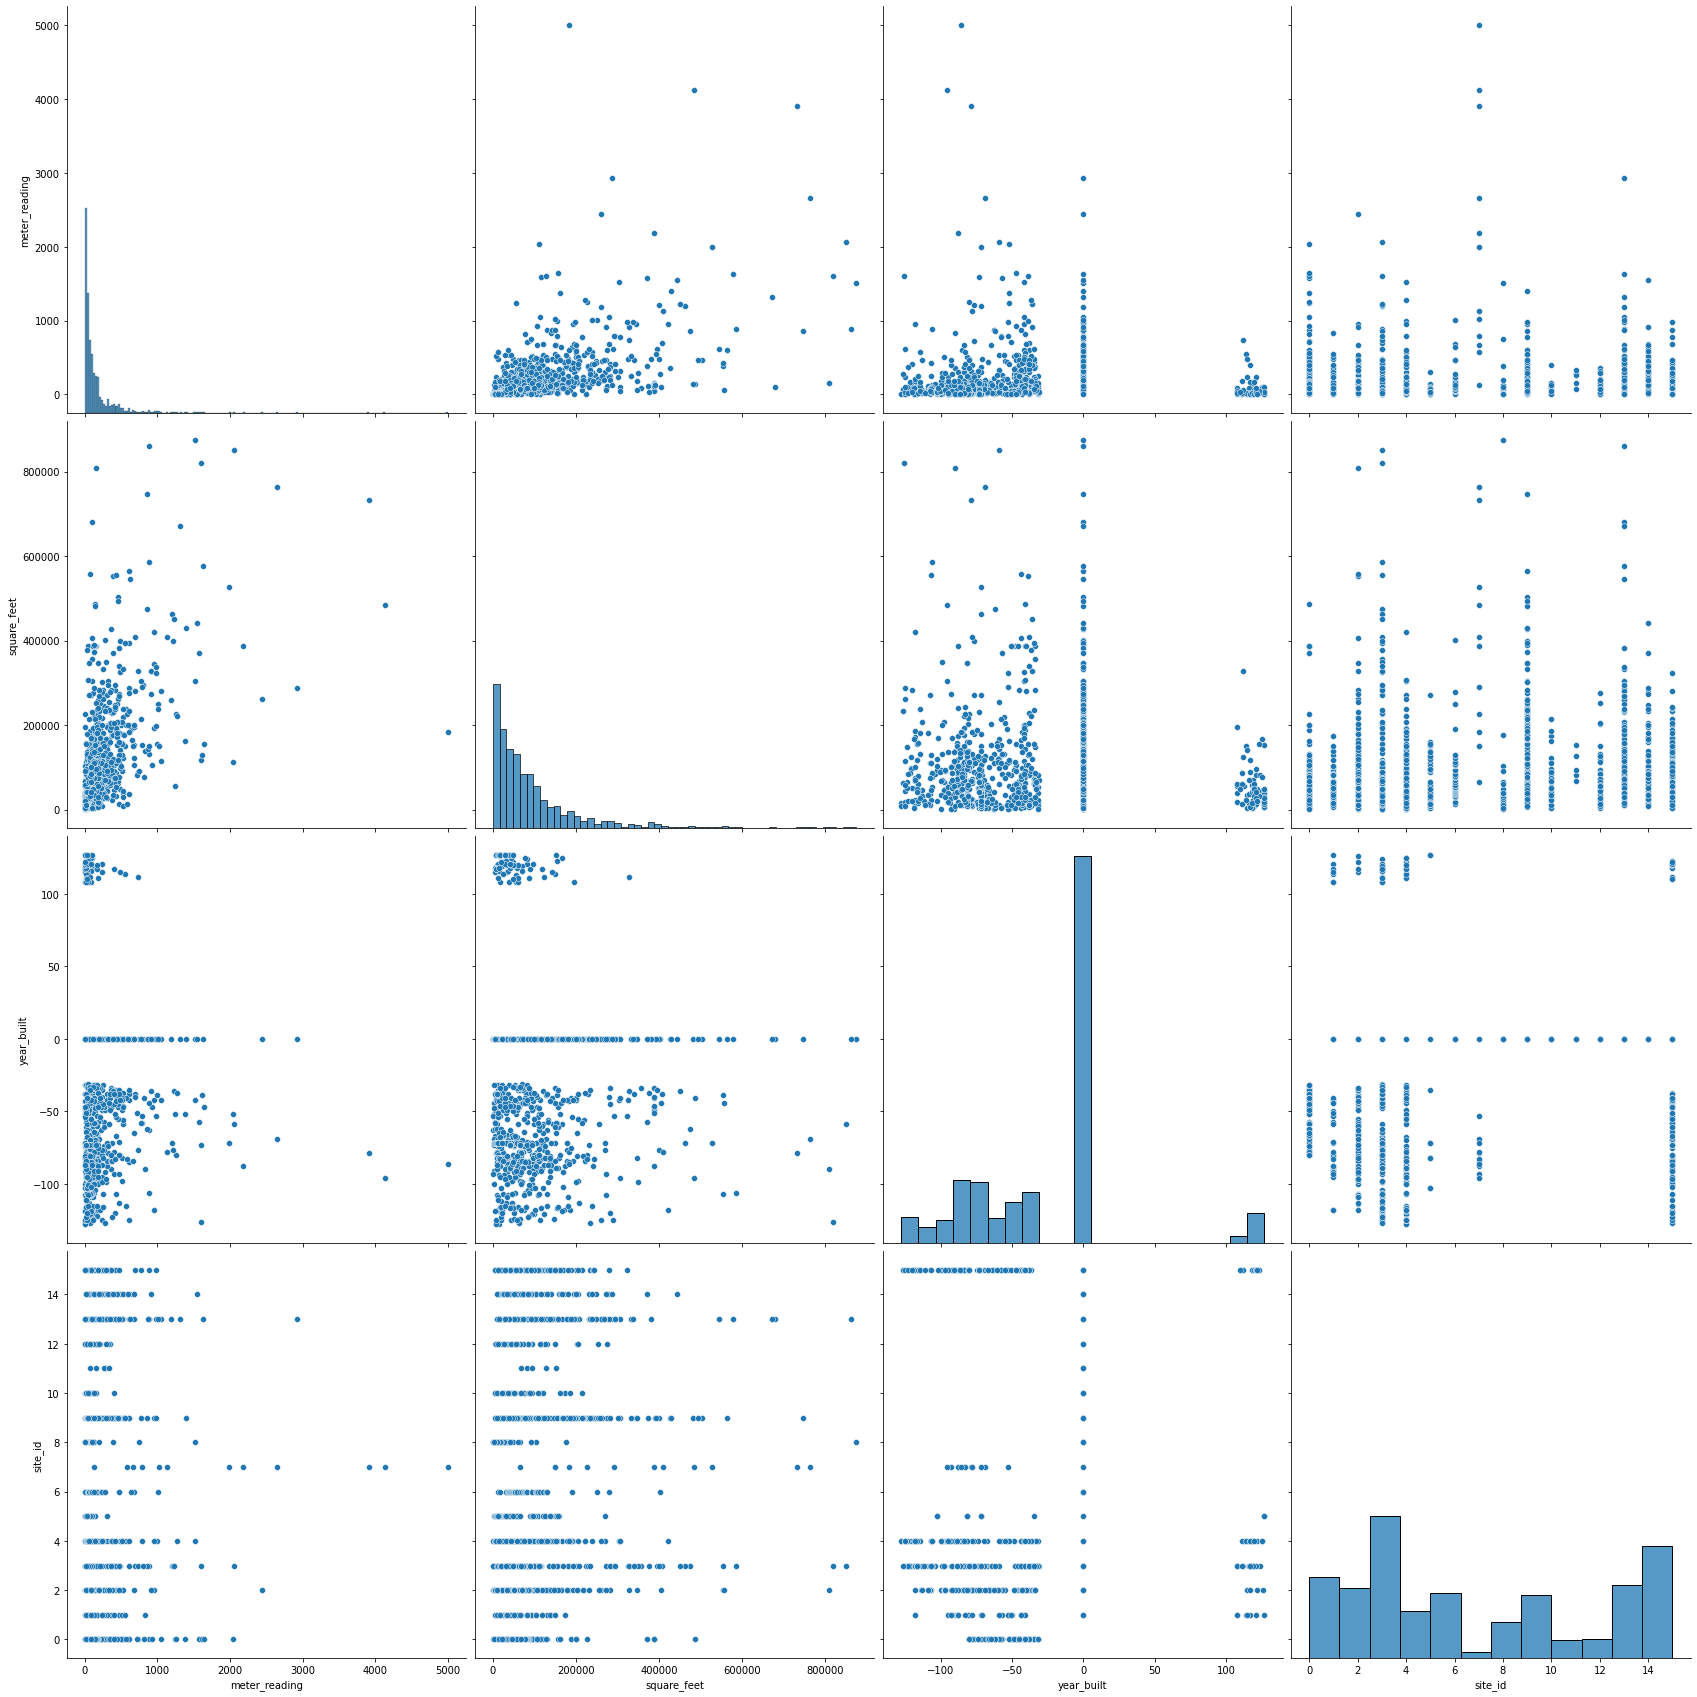

In [9]:

# поиск зависимостей зданий
data_corr_meta = pd.DataFrame(energy.groupby("building_id").median(),
        columns = ["meter_reading", 
            "square_feet",
            "year_built",
            "site_id"])
data_corr_meta.dropna(inplace = True)
sns.pairplot(data_corr_meta, height = 6)
plt.show()
del data_corr_meta

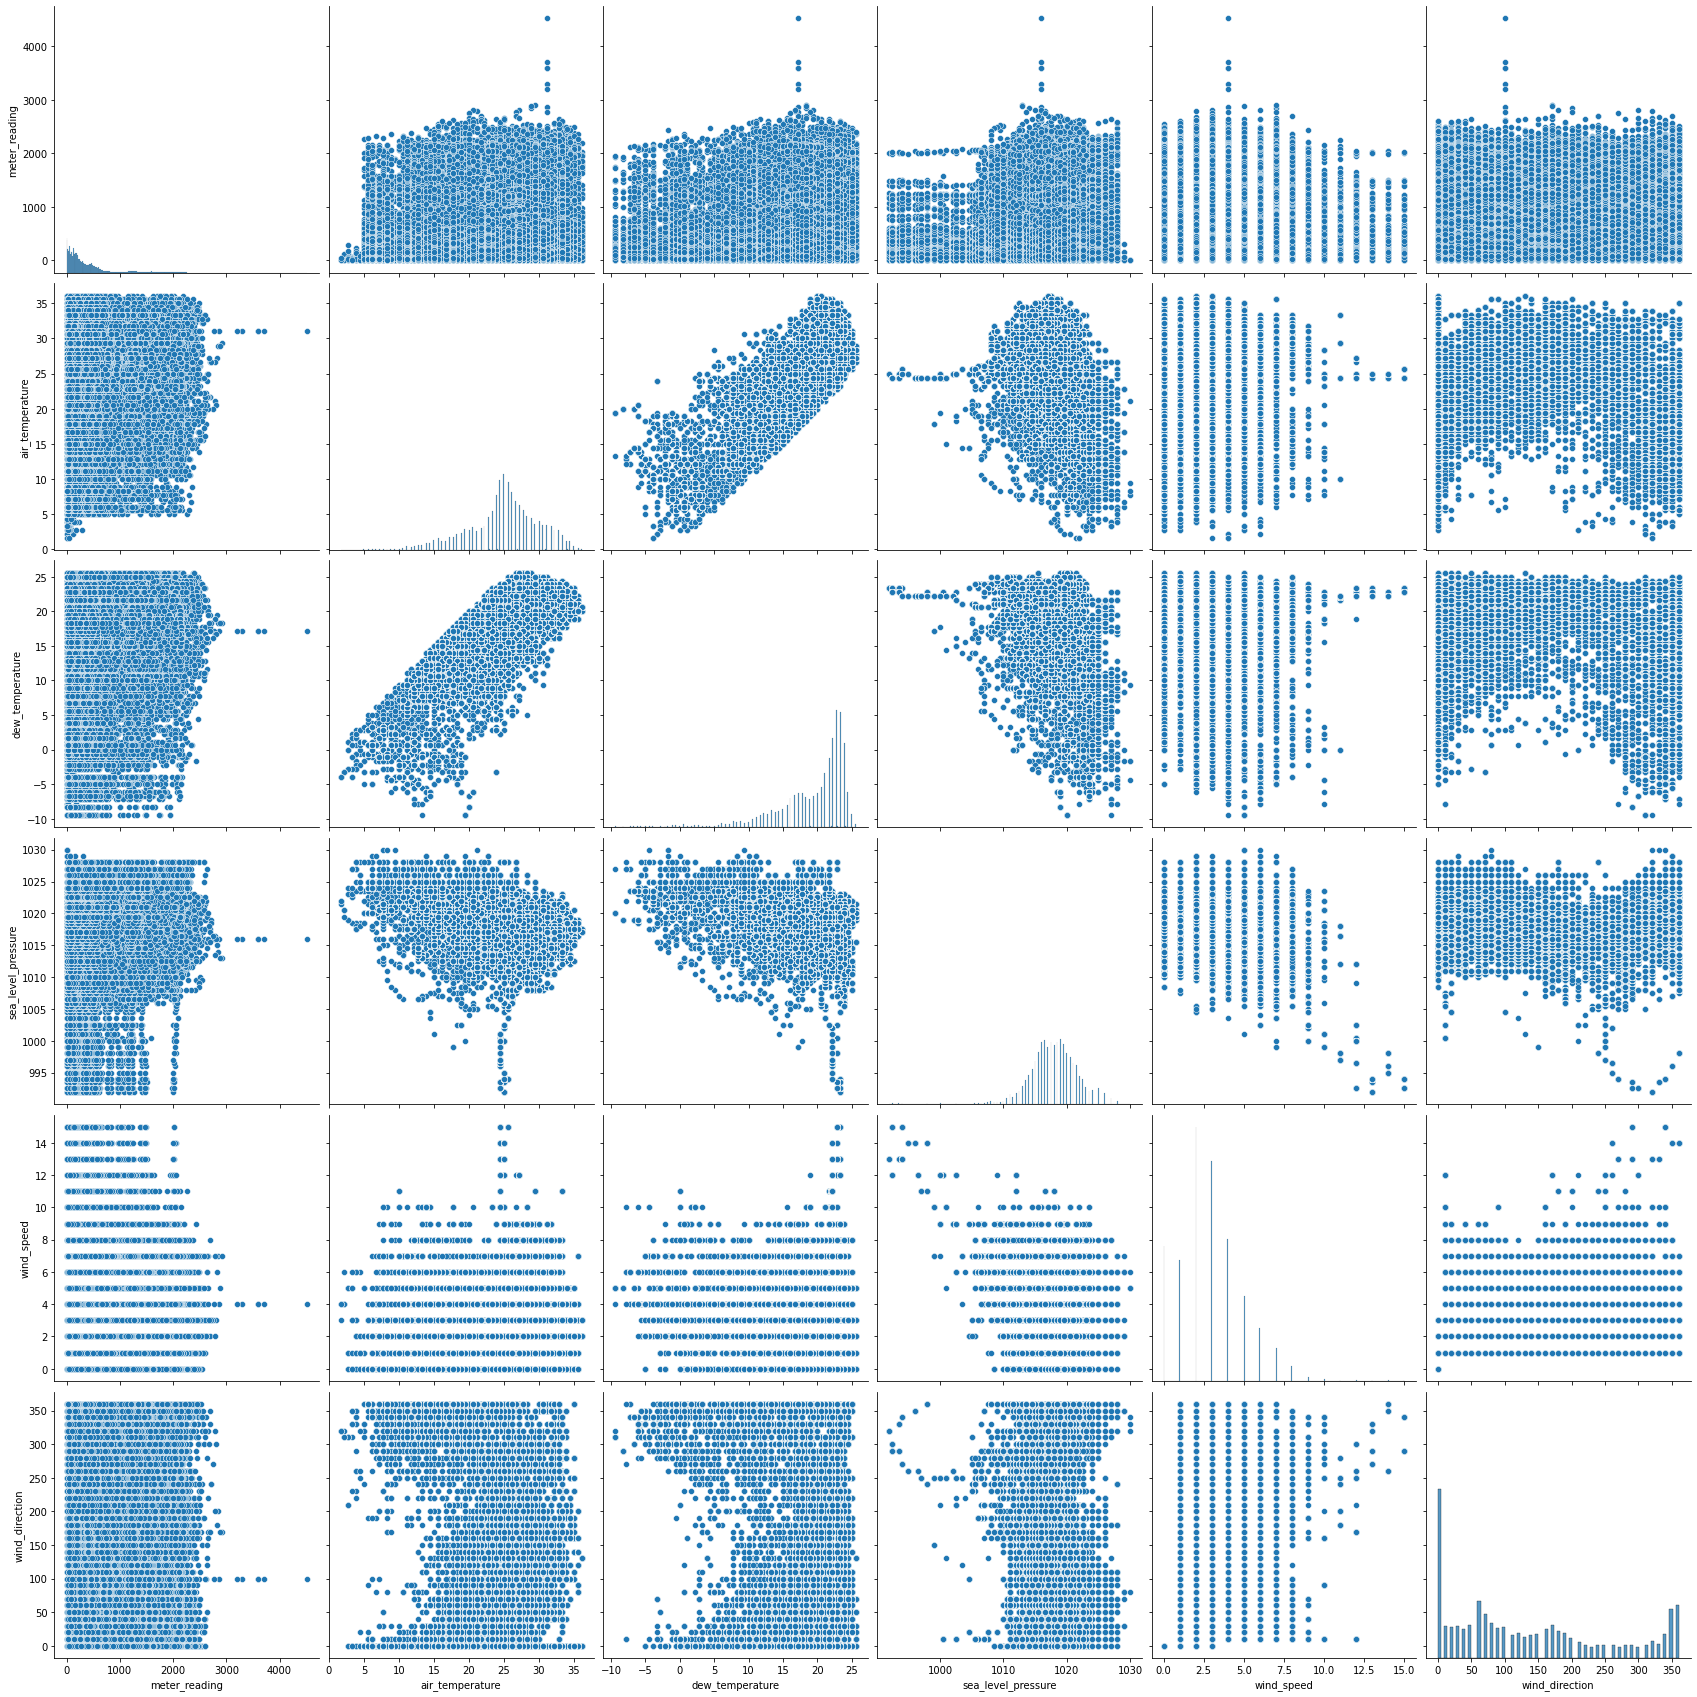

In [10]:

# Поиск зависимостей погода
data_corr_weather = pd.DataFrame(energy[energy["site_id"] == 0],
        columns = ["meter_reading", 
            "air_temperature",
            "dew_temperature",
            "sea_level_pressure",
            "wind_speed",
            "wind_direction"])
data_corr_weather.dropna(inplace = True)
sns.pairplot(data_corr_weather, height = 4)
plt.show()
del data_corr_weather


--- 138.0142912864685 seconds ---
--- 138.74932503700256 seconds ---
--- 1204.1911656856537 seconds ---


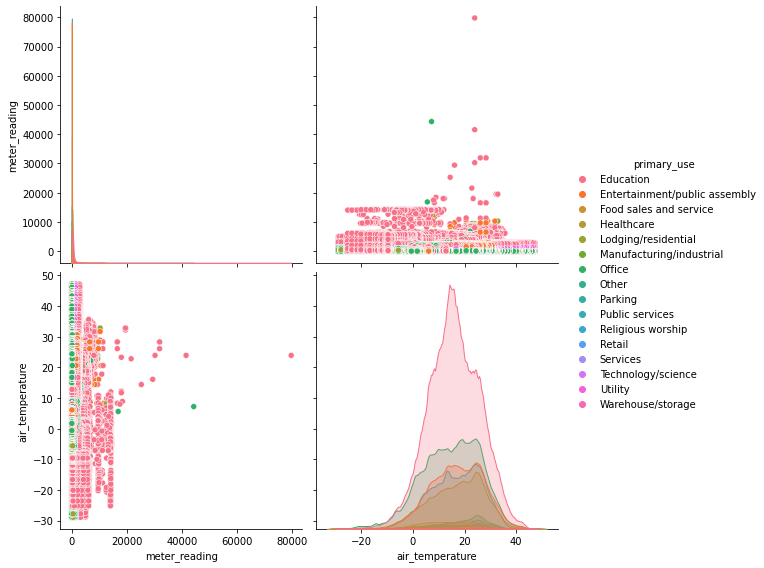

--- 1585.846039056778 seconds ---


In [11]:

# поиск зависимостей тип зданий 

data_corr_temp_primary = pd.DataFrame(energy,
    columns=["meter_reading", 
    "air_temperature", 
    "primary_use"])
print("--- %s seconds ---" % (time.time() - start_time))
data_corr_temp_primary.dropna(inplace=True)
print("--- %s seconds ---" % (time.time() - start_time))
sns.pairplot(data_corr_temp_primary , hue="primary_use", height=4) #
print("--- %s seconds ---" % (time.time() - start_time))
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))
del data_corr_temp_primary

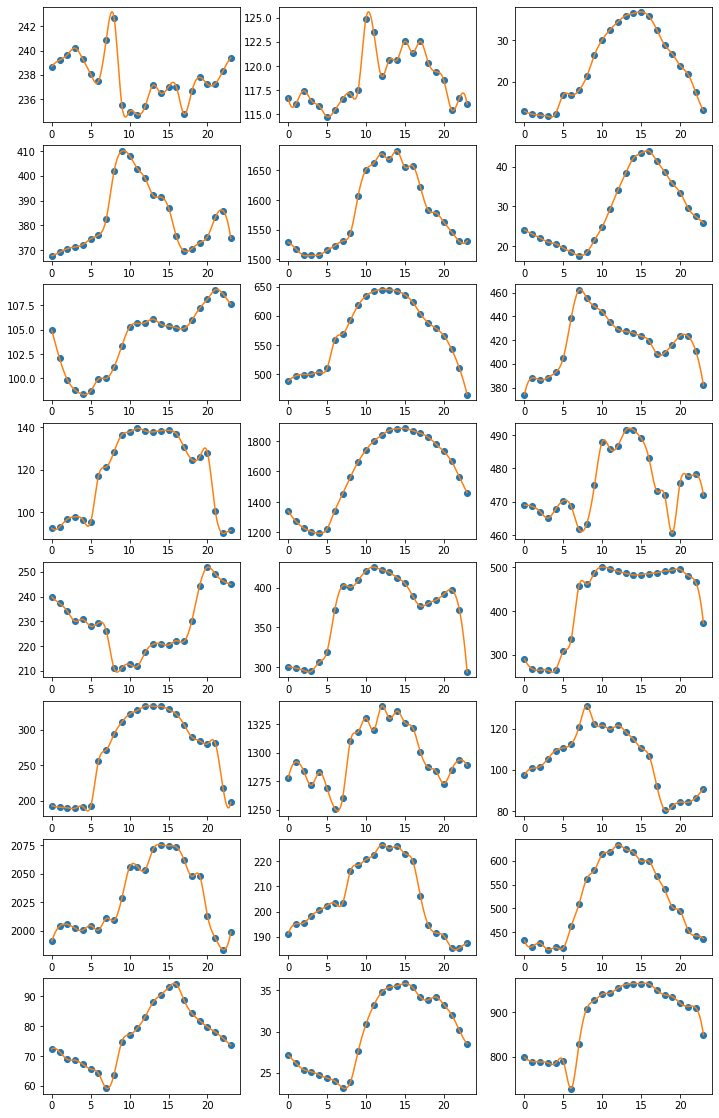

In [12]:
# Поиск зависимостей время

energy["hour"] = energy["timestamp"].dt.hour.astype("int8")
fig = plt.figure(figsize=(12,20))
for i in range(0,24):
    fig.add_subplot(8,3, i + 1)
    df_i = energy[(energy["building_id"] == i) & (energy["meter_reading"]) > 0]
    df_i_hourly = df_i.groupby("hour").mean().reset_index()
    x = np.arange(0, 24)
    y = interp1d(x, df_i_hourly["meter_reading"], kind = "cubic")
    xn = np.arange(0, 23.1, 0.1)
    yn = y(xn)
    plt.plot(np.arange(0, 24), df_i_hourly["meter_reading"],"o", xn, yn, "-")
plt.show()


In [13]:
# поиск зависимости даты 

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2015-12-31', end='2017-01-01')
us_holidays = calendar().holidays(start = dates_range.min(), end = dates_range.max())

In [14]:
energy["dayofweek"] = energy["timestamp"].dt.dayofweek.astype("int8")
energy["day"] = energy["timestamp"].dt.day.astype("int8")
energy["dayofyear"] = energy["timestamp"].dt.dayofyear.astype("int8")
energy["month"] = energy["timestamp"].dt.month.astype("int8")
energy["week"] = energy["timestamp"].dt.week.astype("int8")
energy["date"] = pd.to_datetime(energy["timestamp"].dt.date)
energy["is_holiday"] = (energy['date'].isin(us_holidays)).astype("int8")

C:\Users\mixai\AppData\Local\Temp\ipykernel_17256\360756375.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  energy["week"] = energy["timestamp"].dt.week.astype("int8")


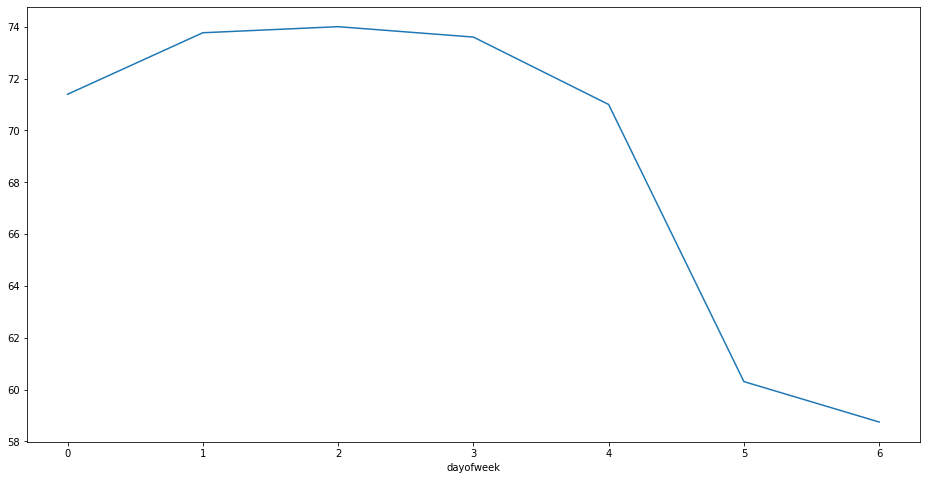

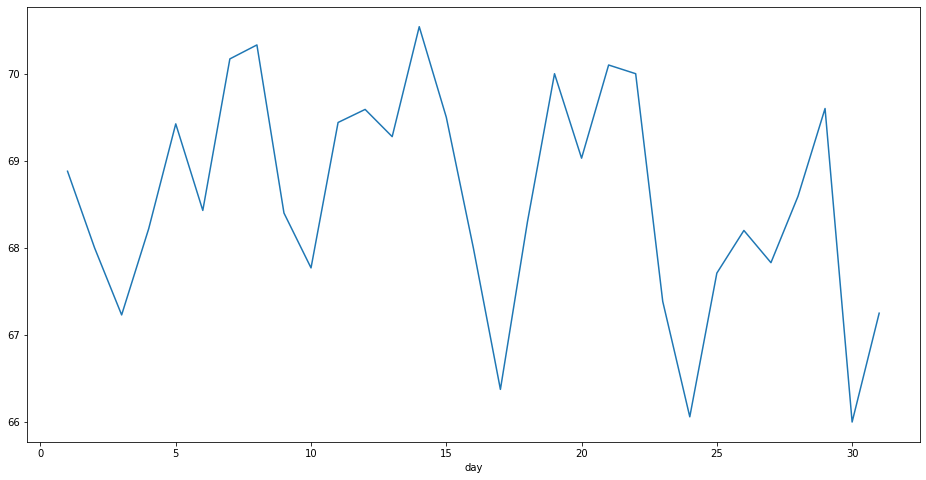

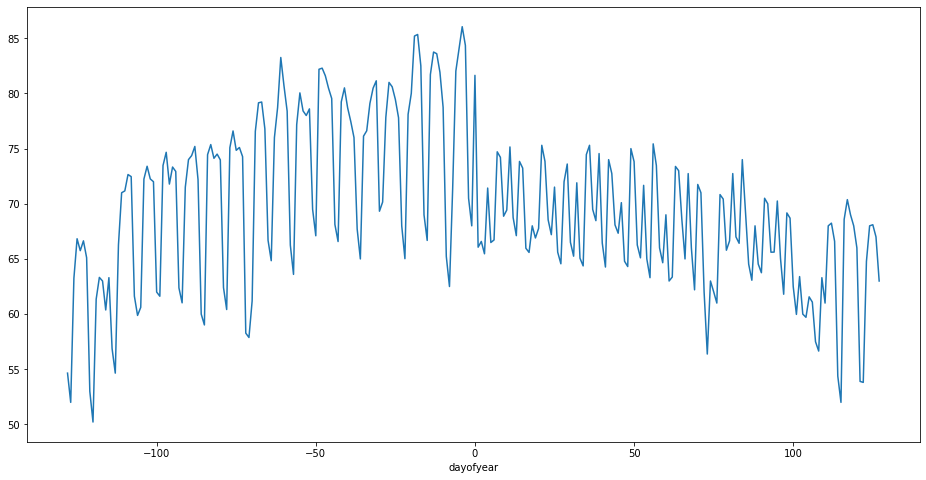

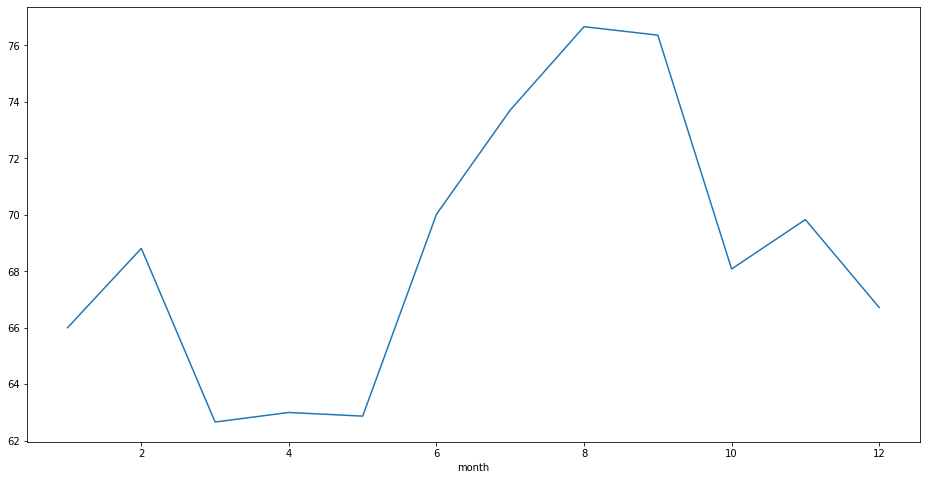

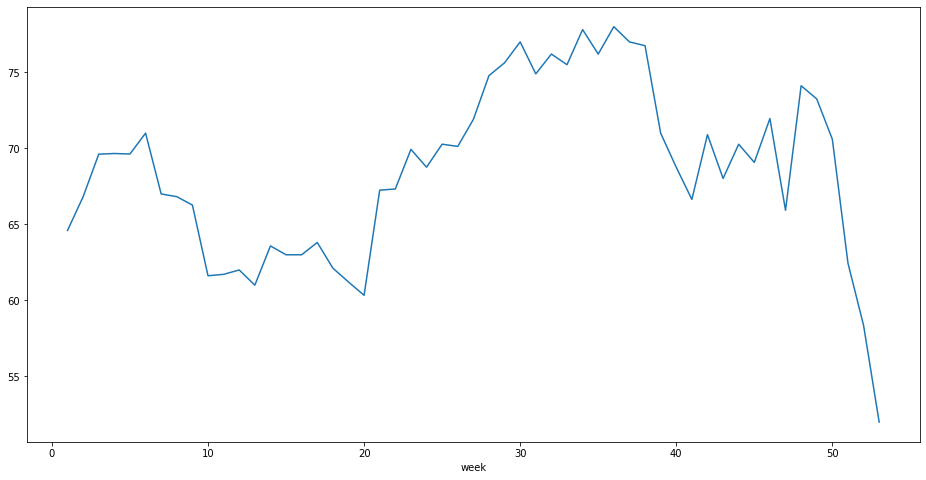

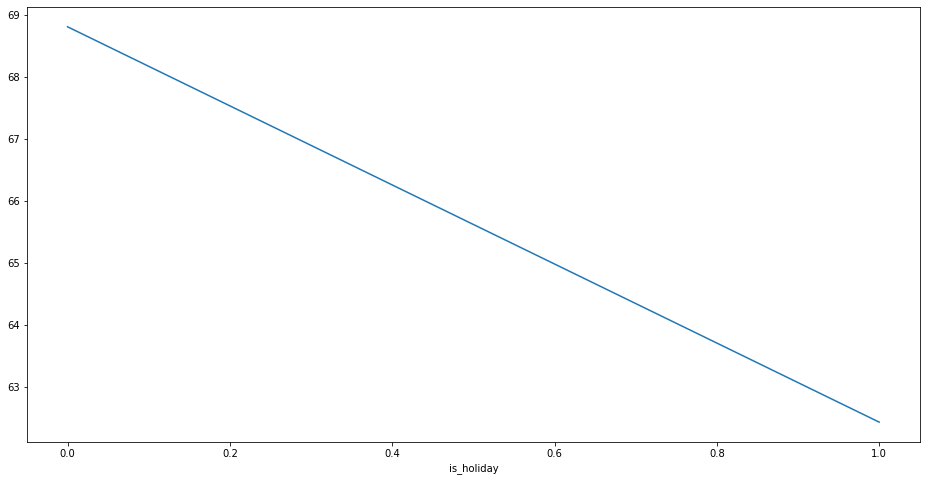

In [15]:
for col in ["dayofweek", "day", "dayofyear", "month", "week", "is_holiday"]:
    energy.groupby(col).median()["meter_reading"].plot()
    plt.show()

In [16]:
# очистка памяти 
del energy